# Ground-State: J1-J2 model

In this code we will use NetKet to obtain the ground state of the J1-J2 model in one-dimension with periodic boundary conditions, using a Neural Network variational wave-function. 

The Hamiltonian of the model is given by:

$$ H = \sum_{i=1}^{L} J_{1}\vec{\sigma}_{i} \cdot \vec{\sigma}_{i+1} + J_{2} \vec{\sigma}_{i} \cdot \vec{\sigma}_{i+2} $$

where the sum is over sites of the 1-D chain. Here $\vec{\sigma}=(\sigma^x,\sigma^y,\sigma^z)$ is the vector of Pauli matrices. 

## Objectives:
    1. Defining custom Hamiltonians
    2. Defining the machine (variational ansatz)
    3. Variational Monte Carlo Optimisation
    4. Measuring observables
    5. Data Visualisation
    6. Sanity Check: Exact Diagonalisation

In [21]:
# ensure we run on the CPU
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

# Import netket library
import netket as nk

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## 1) Defining a Custom Hamiltonian

The first thing to do is to define the graph (lattice) on which to specify the Hamiltonian. Here we would like to build a one-dimensional graph with both nearest and next nearest neighbour bonds. The graph is created in the ``nk.graph.CustomGraph`` class. To initialise the class we simply provide a list of edges in the ``[[site_i, site_j, edge_color], ...]``

In [2]:
#Couplings J1 and J2
J = [1, 0.2]
L = 14

In [3]:
# Define custom graph
edge_colors = []
for i in range(L):
    edge_colors.append([i, (i+1)%L, 1])
    edge_colors.append([i, (i+2)%L, 2])

# Define the netket graph object
g = nk.graph.Graph(edges=edge_colors)

We specify a different ``color`` for each type of bond so as to define a different operator for each of them.
Next, we define the relevant bond operators.

In [4]:
#Sigma^z*Sigma^z interactions
sigmaz = [[1, 0], [0, -1]]
mszsz = (np.kron(sigmaz, sigmaz))

#Exchange interactions
exchange = np.asarray([[0, 0, 0, 0], [0, 0, 2, 0], [0, 2, 0, 0], [0, 0, 0, 0]])

bond_operator = [
    (J[0] * mszsz).tolist(),
    (J[1] * mszsz).tolist(),
    (-J[0] * exchange).tolist(),  
    (J[1] * exchange).tolist(),
]

bond_color = [1, 2, 1, 2]

**Side Remark**: Notice the minus sign in front of the exchange. This is simply a basis rotation corresponding to the Marshall sign rule (as an exercise, change the sign of this exchange and observe that the exact diagonalization results in Section 6 do not change). The goal of this basis rotation is to speed up the convergence of the Monte Carlo simulations of the wave-function (by providing a good variational sign structure to start with), but in principle the converged results should be identical in both bases. Note further that this sign change is useful at low frustration (such as here 𝐽2=0.2
), but may actually be not optimal at stronger frustration. As a bonus exercise, repeat the calculation with 𝐽2=0.8
, and see which basis (i.e. which sign in front of the exchange) leads to faster convergence.

Before defining the Hamiltonian, we also need to specify the Hilbert space. For our case, this would be the chain spin-half degrees of freedom.

Before defining the Hamiltonian, we also need to specify the Hilbert space. For our case, this would be the chain spin-half degrees of freedom.

In [5]:
# Spin based Hilbert Space
hi = nk.hilbert.Spin(s=0.5, total_sz=0.0, N=g.n_nodes)

Note that we impose here the total magnetization to be zero (it turns out to be the correct magnetization for the ground-state). As an exercise, check that the energy of the lowest state in other magnetization sectors is larger.

Next, we define the custom graph Hamiltonian using the nk.operator.GraphOperator class, by providing the hilbert space hi, the bond operators bondops=bond_operator and the corresponding bond color bondops_colors=bond_color. The information about the graph (bonds and bond colors) are contained within the nk.hilbert.Spin object hi.

In [6]:
# Custom Hamiltonian operator
op = nk.operator.GraphOperator(hi, graph=g, bond_ops=bond_operator, bond_ops_colors=bond_color)

## 2) Defining the Machine

For this code, we shall use the most common type of neural network: fully connected feedforward neural network ``nk.machine.FFNN``. Other types of neural networks available will be discussed in other tutorials.

In [10]:
import netket.nn as nknn
import flax.linen as nn

import jax.numpy as jnp

class FFNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=2*x.shape[-1], 
                     use_bias=True, 
                     param_dtype=np.complex128, 
                     kernel_init=nn.initializers.normal(stddev=0.01), 
                     bias_init=nn.initializers.normal(stddev=0.01)
                    )(x)
        x = nknn.log_cosh(x)
        x = jnp.sum(x, axis=-1)
        return x
        
model = FFNN()

In [11]:
# Define a função de perda (loss function) para o treinamento
def loss(params, structure_factor):
    output = model.apply({'params': params}, structure_factor)
    return jnp.mean(output)
# Função de callback para salvar os parâmetros durante o treinamento
def save_params(step, params, energy):
    trained_params_list.append(params.copy())
    parameters_list.append(energy.state.parameters.copy())
    iii.append(1)
    return True
def info(e):
    head   = list(e.keys())[0]
    body   = list(e[head].keys())
    bias   = e[head][body[0]]
    kernel = e[head][body[1]]
    return  head, body, list(bias), list(kernel)
def real(c):
    return float(np.real(c))  
def img(c):
    return float(np.imag(c))    
def r_i(c):
    return real(c),img(c)  

## 3) Variational Monte Carlo Optimisation

We have now set up our model (Hamiltonian, Graph, Hilbert Space) and can proceed to optimise the variational ansatz we chose, namely the ``ffnn`` machine.

To setup the variational Monte Carlo optimisation tool, we have to provide a sampler ``nk.sampler`` and an optimizer ``nk.optimizer``.

In [12]:
# We shall use an exchange Sampler which preserves the global magnetization (as this is a conserved quantity in the model)
sa = nk.sampler.MetropolisExchange(hilbert=hi, graph=g, d_max = 2)

# Construct the variational state
vs = nk.vqs.MCState(sa, model, n_samples=1008)

# We choose a basic, albeit important, Optimizer: the Stochastic Gradient Descent
opt = nk.optimizer.Sgd(learning_rate=0.01)

# Stochastic Reconfiguration
sr = nk.optimizer.SR(diag_shift=0.01)

# We can then specify a Variational Monte Carlo object, using the Hamiltonian, sampler and optimizers chosen.
# Note that we also specify the method to learn the parameters of the wave-function: here we choose the efficient
# Stochastic reconfiguration (Sr), here in an iterative setup
gs = nk.VMC(hamiltonian=op, optimizer=opt, variational_state=vs, preconditioner=sr)

## 4) Measuring Observables

Before running the optimization, it can be helpful to add some observables to keep track off during the optimization. For our purpose, let us measure the antiferromagnetic structure factor, defined as:

$$ \frac{1}{L} \sum_{ij} \langle \hat{\sigma}_{i}^z \cdot \hat{\sigma}_{j}^z\rangle e^{i\pi(i-j)}$$.

In [13]:
# We need to specify the local operators as a matrix acting on a local Hilbert space 
sf = []
sites = []
structure_factor = nk.operator.LocalOperator(hi, dtype=complex)
for i in range(0, L):
    for j in range(0, L):
        structure_factor += (nk.operator.spin.sigmaz(hi, i)*nk.operator.spin.sigmaz(hi, j))*((-1)**(i-j))/L


We can now optimize our variational ansatz. The optimization data for each iteration will be stored in a log file, which contains the following information:
1. Mean, variance and uncertainty in the Energy $ \langle \hat{H} \rangle $
2. Mean, variance and uncertainty in the Energy Variance, $ \langle\hat{H}^{2}\rangle-\langle \hat{H}\rangle^{2}$.
3. Acceptance rates of the sampler
4. Mean, variance and uncertainty of observables (if specified)

Now let's learn the ground-state!

In [14]:
import warnings
warnings.filterwarnings("ignore")

In [16]:
# Define uma lista para armazenar os parâmetros do modelo durante o treinamento
trained_params_list = []
parameters_list     = []
iii                 = []

In [17]:
# Run the optimization protocol
gs.run(out='test', n_iter=600, obs={'Structure Factor': structure_factor}, callback=save_params)

  0%|                                                   | 0/600 [00:00<?, ?it/s]

(JsonLog('test', mode=write, autoflush_cost=0.005)
   Runtime cost:
   	Log:    0.22664141654968262
   	Params: 0.128645658493042,)

In [18]:
head, body, bias_list,kernel_list = info(parameters_list[-1])

In [22]:
real_df = pd.DataFrame()
img_df  = pd.DataFrame()
for param in parameters_list:
    head, body, bias_list,kernel_list = info(param)
    real_v = [];img_v = []
    for bias in bias_list:
        nr, ni = r_i(bias); 
        real_v.append(nr)
        img_v.append(ni)   
    
    real_row_df = pd.DataFrame([real_v])
    img_row_df  = pd.DataFrame([img_v])
        
    real_df = pd.concat([real_df,real_row_df])
    img_df  = pd.concat([img_df,img_row_df])  

In [23]:
real_df.insert(0, 'id', range(1, 1 + len(real_df)))
img_df.insert(0, 'id', range(1, 1 + len(img_df)))

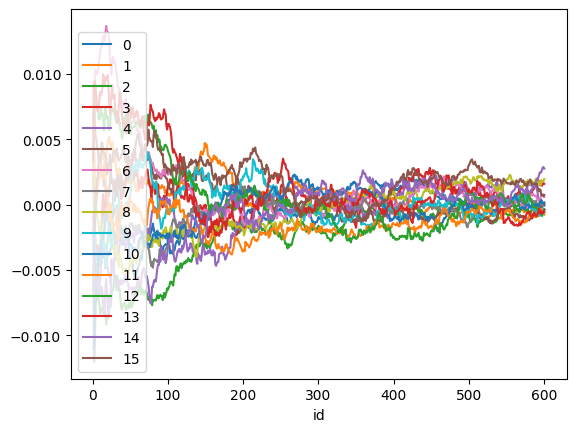

In [24]:
real_df.plot('id',y=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
plt.show()

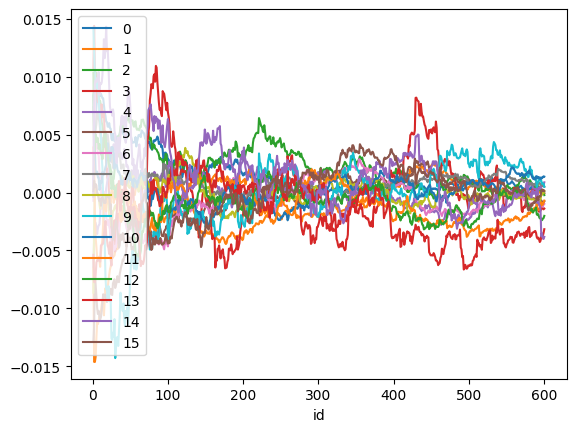

In [25]:
img_df.plot('id',y=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
plt.show()

In [26]:
real_kernel_df = pd.DataFrame()
img_kernel_df  = pd.DataFrame()
for param in parameters_list:
    head, body, bias_list,kernel_list = info(param)
    real_v = [];img_v = []
    for ks in kernel_list:
        for k in ks:
            nr, ni = r_i(k); 
            real_v.append(nr)
            img_v.append(ni) 
    real_row_df = pd.DataFrame([real_v])
    img_row_df  = pd.DataFrame([img_v])
    
    real_kernel_df = pd.concat([real_kernel_df,real_row_df])
    img_kernel_df  = pd.concat([img_kernel_df,img_row_df])  

In [27]:
real_kernel_df.insert(0, 'id', range(1, 1 + len(real_kernel_df)))
img_kernel_df.insert(0, 'id', range(1, 1 + len(img_kernel_df)))

In [28]:
len(real_kernel_df)

600

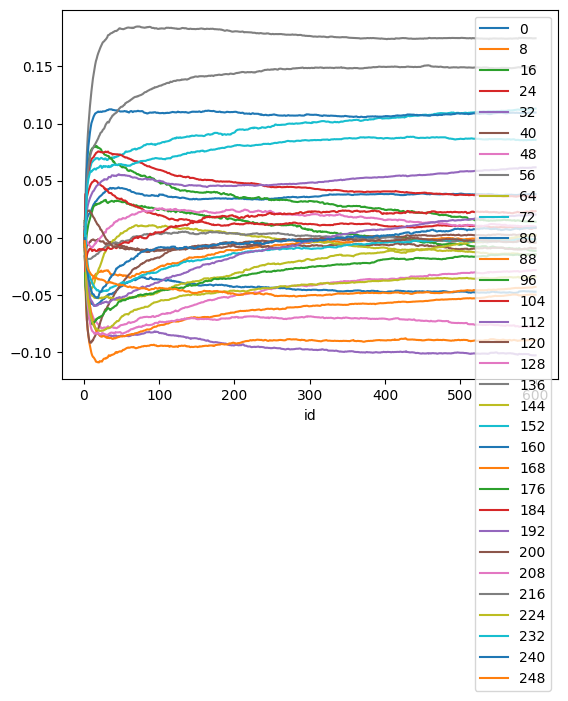

In [35]:
yt = []
for i in range(0,256): 
    if i % 8==0:
        yt.append(i)  
real_kernel_df.plot('id',y=yt)
plt.show()

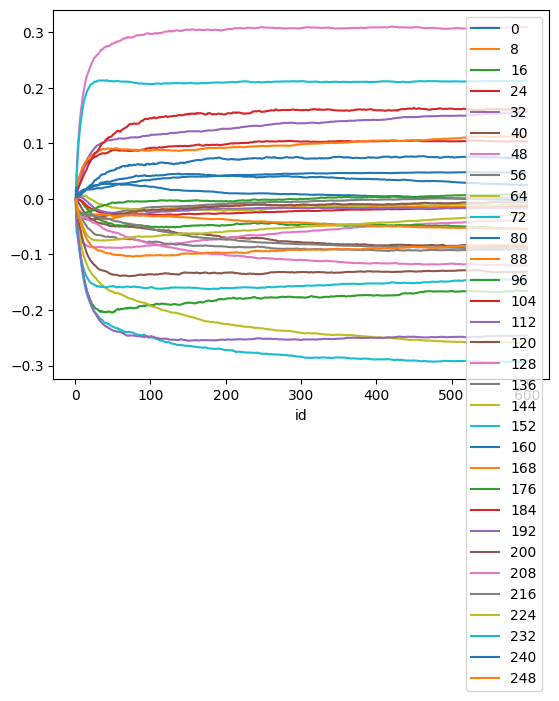

In [36]:
yt = []
for i in range(0,256): 
    if i % 8==0:
        yt.append(i)  
img_kernel_df.plot('id',y=yt)
plt.show()

## 5) Data Visualisation

Now that we have optimized our machine to find the ground state of the $J_1-J_2$ model, let's look at what we have.
The relevant data are stored in the ".log" file while the optimized parameters are in the ".wf" file. The files are all in json format.

We shall extract the energy as well as specified observables (antiferromagnetic structure factor in our case) from the ".log" file.

In [12]:
# Load the data from the .log file
import json

data=json.load(open("test.log"))

iters = data['Energy']['iters']
energy=data['Energy']['Mean']['real']
sf=data['Structure Factor']['Mean']['real']

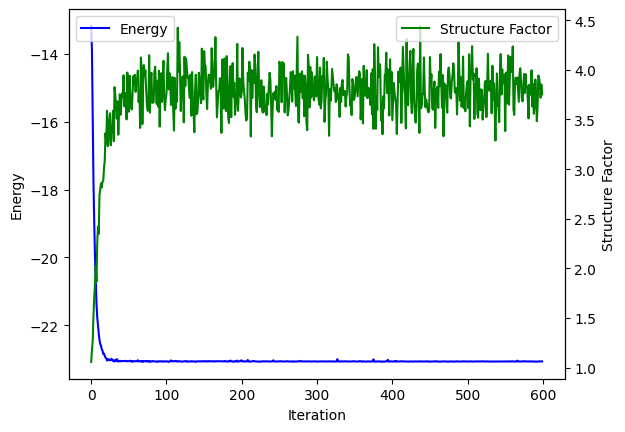

In [13]:
fig, ax1 = plt.subplots()
ax1.plot(iters, energy, color='blue', label='Energy')
ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
ax2 = ax1.twinx() 

ax2.plot(iters, np.array(sf), color='green', label='Structure Factor')
ax2.set_ylabel('Structure Factor')
ax1.legend(loc=2)
ax2.legend(loc=1)
plt.show()

Let's also compute the average of those quantities (energy and neel order) over the last 50 iterations where the optimization seems to have converged.

In [14]:
print(r"Structure factor = {0:.3f}({1:.3f})".format(np.mean(sf[-50:]),
                                              np.std(np.array(sf[-50:]))/np.sqrt(50)))
print(r"Energy = {0:.3f}({1:.3f})".format(np.mean(energy[-50:]), np.std(energy[-50:])/(np.sqrt(50))))

Structure factor = 3.811(0.024)
Energy = -23.061(0.001)


## 6) Sanity Check: Exact Diagonalisation

Now that we have obtained some results using VMC, it is a good time to check the quality of our results (at least for small system sizes). For this purpose, Netket provides exact diagonalisation tools. 

In [15]:
E_gs, ket_gs = nk.exact.lanczos_ed(op, compute_eigenvectors=True)
structure_factor_gs = (ket_gs.T.conj()@structure_factor.to_linear_operator()@ket_gs).real[0,0]

In [17]:
print("Exact Ground-state Structure Factor: {0:.3f}".format(structure_factor_gs))
print("Exact ground state energy = {0:.3f}".format(E_gs[0]))

Exact Ground-state Structure Factor: 3.803
Exact ground state energy = -23.064


So we see that the both energy and the structure factor we obtained is in agreement with the value obtained via exact diagonalisation.